In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# Load your dataset
df = pd.read_csv("/Users/shrey24/Downloads/online_sales.csv")

In [2]:
for col in df.select_dtypes(include=["object"]):
    if col != "Payment Method":
        print("COLUMN:", col)
        print(pd.crosstab(df[col], df["Payment Method"]))
        print("\n")


COLUMN: Date
Payment Method  Credit Card  Debit Card  PayPal
Date                                           
2024-01-01                1           0       0
2024-01-02                0           0       1
2024-01-03                0           1       0
2024-01-04                1           0       0
2024-01-05                0           0       1
...                     ...         ...     ...
2024-08-23                0           0       1
2024-08-24                0           1       0
2024-08-25                1           0       0
2024-08-26                0           0       1
2024-08-27                1           0       0

[240 rows x 3 columns]


COLUMN: Product Category
Payment Method    Credit Card  Debit Card  PayPal
Product Category                                 
Beauty Products             0           0      40
Books                      40           0       0
Clothing                    0          40       0
Electronics                40           0       0
Home Applian

In [3]:
# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Extract month as numeric feature
df["Month"] = df["Date"].dt.month

In [4]:
df["HighRevenue"] = (df["Total Revenue"] > df["Total Revenue"].median()).astype(int)
df["PriceTier"] = pd.qcut(df["Unit Price"], q=3, labels=["Low", "Mid", "High"])

In [5]:
df.head()

,Transaction ID,Date,Product Category,Product Name,Units Sold,Unit Price,Total Revenue,Region,Payment Method,Month,HighRevenue,PriceTier
0,10001,2024-01-01,Electronics,iPhone 14 Pro,2,999.99,1999.98,North America,Credit Card,1,1,High
1,10002,2024-01-02,Home Appliances,Dyson V11 Vacuum,1,499.99,499.99,Europe,PayPal,1,1,High
2,10003,2024-01-03,Clothing,Levi's 501 Jeans,3,69.99,209.97,Asia,Debit Card,1,1,Mid
3,10004,2024-01-04,Books,The Da Vinci Code,4,15.99,63.96,North America,Credit Card,1,0,Low
4,10005,2024-01-05,Beauty Products,Neutrogena Skincare Set,1,89.99,89.99,Europe,PayPal,1,0,Mid


## EDA

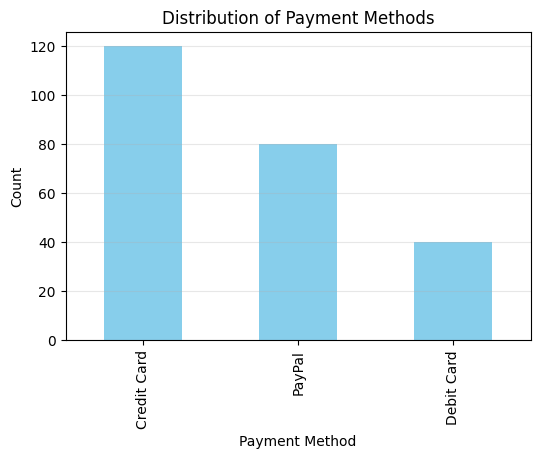

In [6]:
plt.figure(figsize=(6,4))
df["Payment Method"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Distribution of Payment Methods")
plt.xlabel("Payment Method")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()


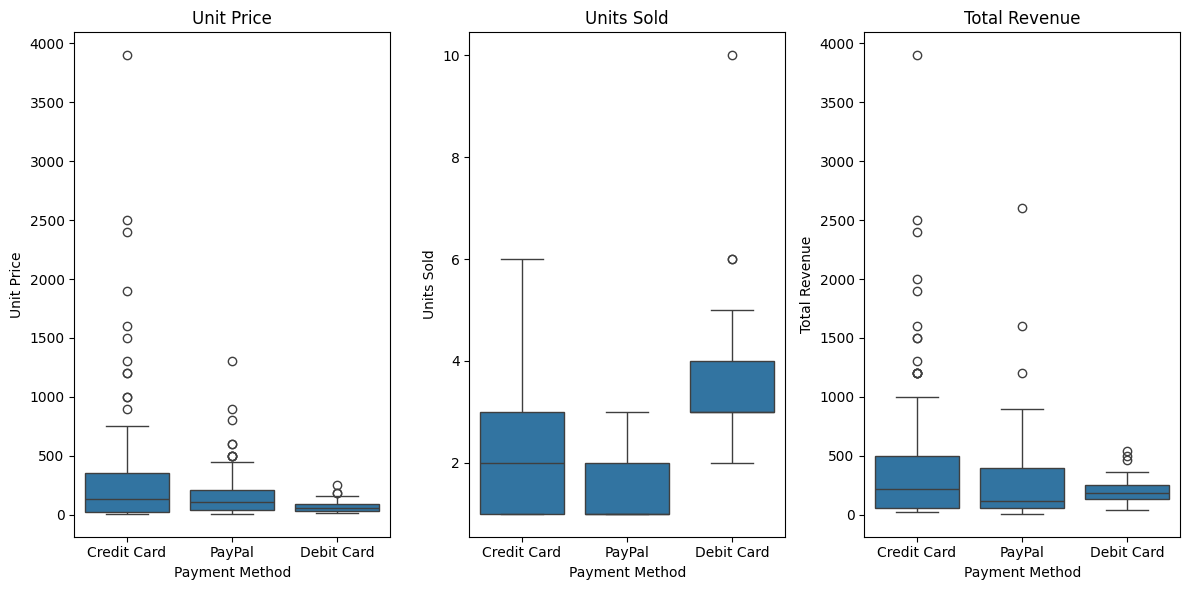

In [7]:
numeric_vars = ["Unit Price", "Units Sold", "Total Revenue"]

plt.figure(figsize=(12,6))
for i, var in enumerate(numeric_vars):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x="Payment Method", y=var, data=df)
    plt.title(var)

plt.tight_layout()
plt.show()


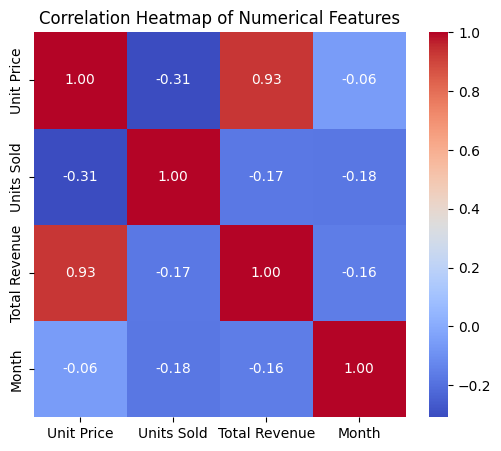

In [8]:
plt.figure(figsize=(6,5))
sns.heatmap(df[["Unit Price","Units Sold","Total Revenue","Month"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


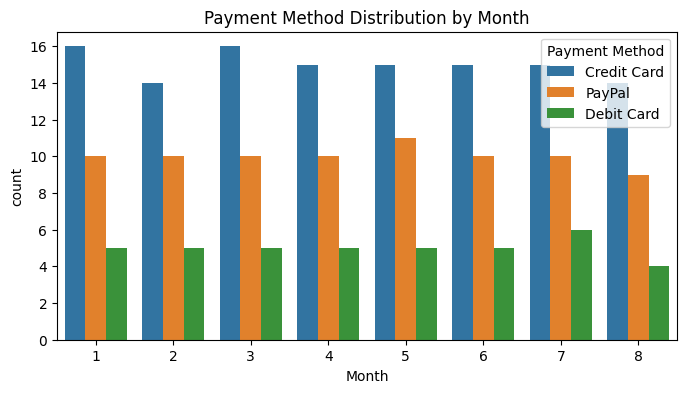

In [9]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x="Month", hue="Payment Method")
plt.title("Payment Method Distribution by Month")
plt.show()


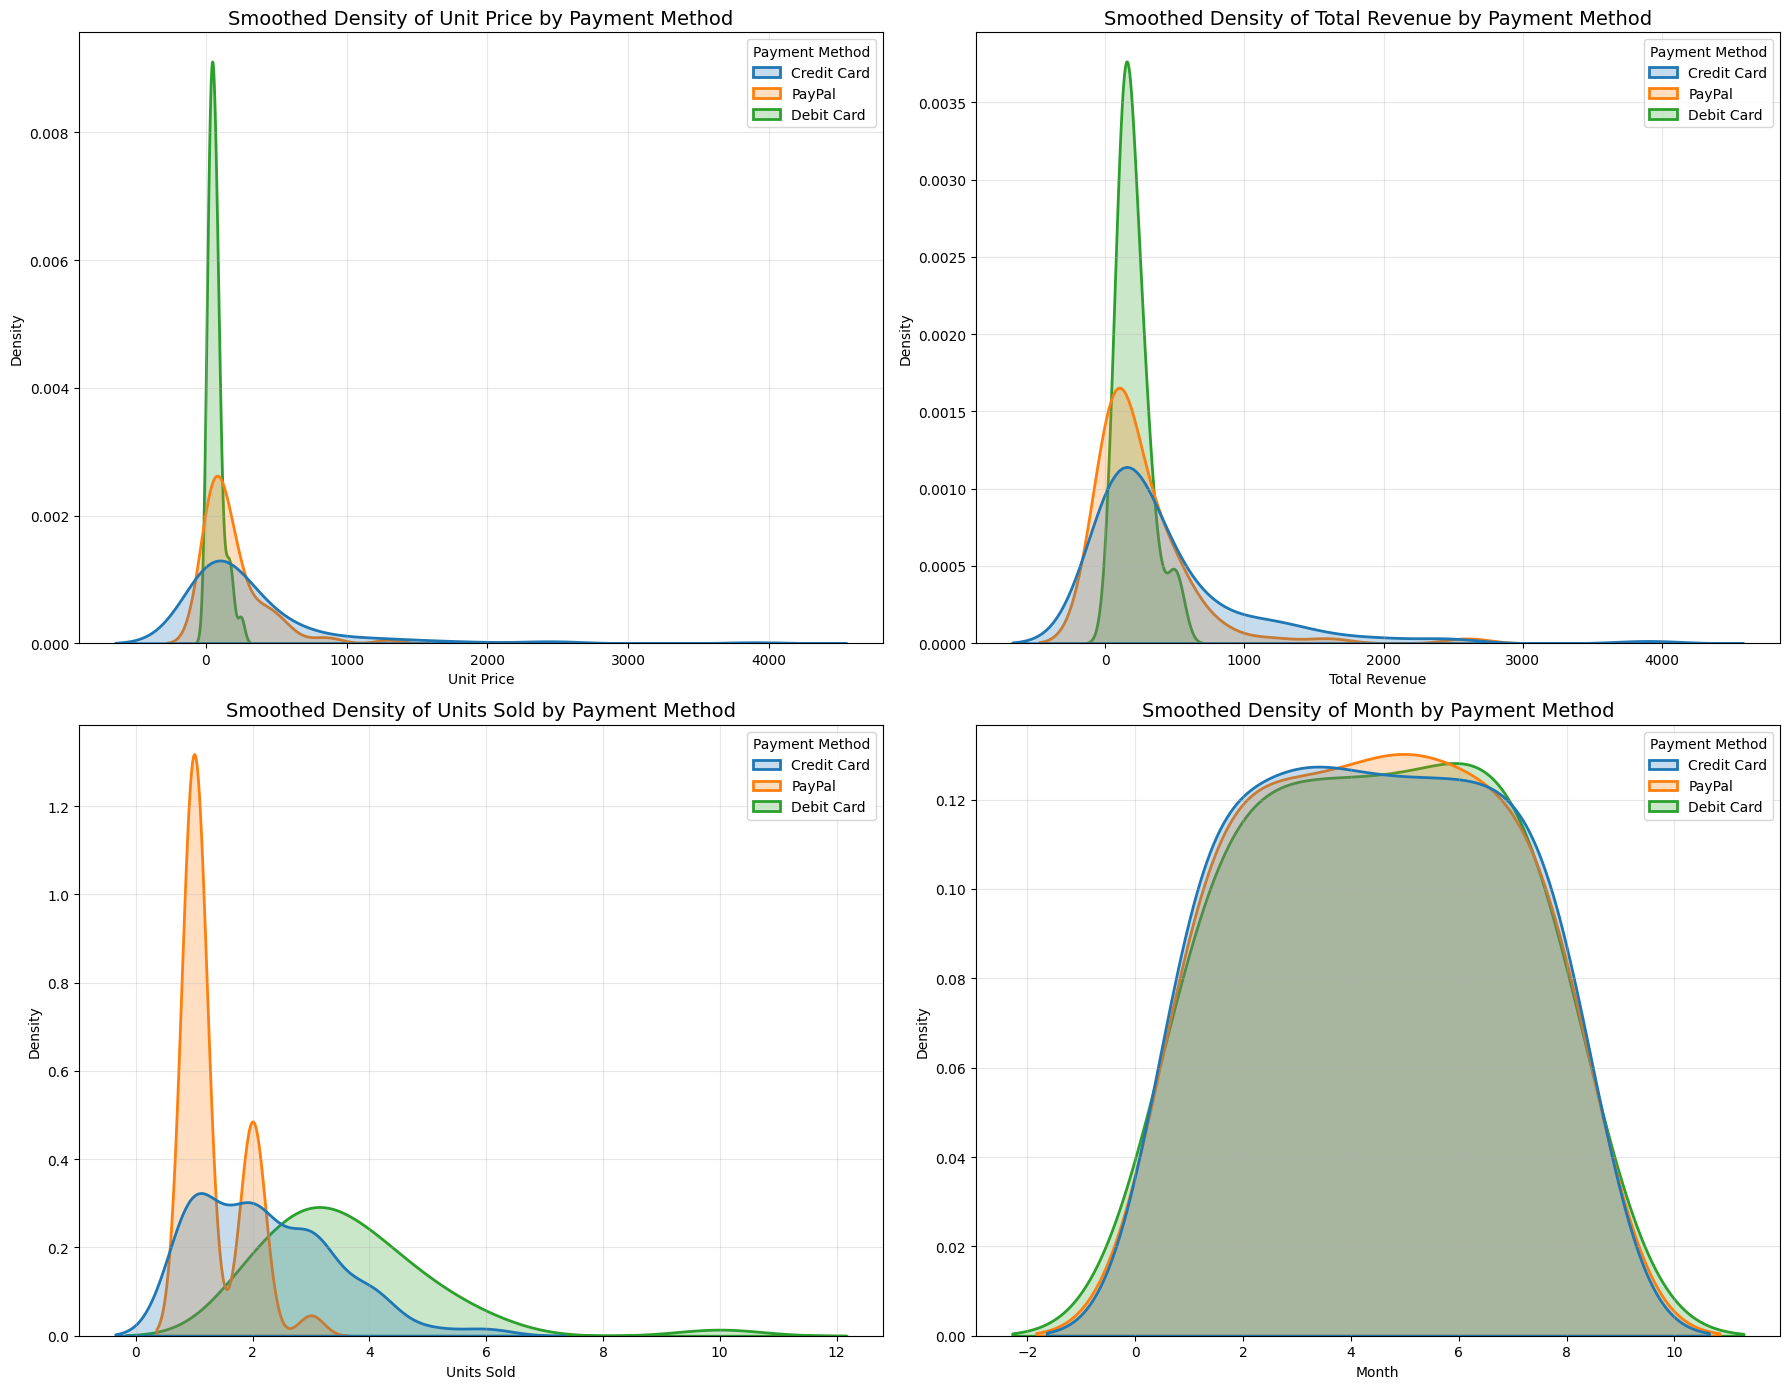

In [10]:
# ============================================================
# KDE SMOOTHING — NUMERICAL FEATURES BY PAYMENT METHOD
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

# Numerical variables you are allowed to use (no leakage)
numeric_vars = ["Unit Price", "Total Revenue", "Units Sold", "Month"]

plt.figure(figsize=(18, 14))

for i, var in enumerate(numeric_vars, 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(
        data=df,
        x=var,
        hue="Payment Method",
        fill=True,
        common_norm=False,
        alpha=0.25,
        linewidth=2
    )
    plt.title(f"Smoothed Density of {var} by Payment Method", fontsize=14)
    plt.xlabel(var)
    plt.ylabel("Density")
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Modeling

Payment Method Mapping:
  Payment Method  Payment_Code
0    Credit Card             0
1         PayPal             2
2     Debit Card             1 


10-FOLD CROSS-VALIDATION (ACCURACY)

CV Scores: [0.75       0.70833333 0.83333333 0.625      0.54166667 0.54166667
 0.75       0.79166667 0.79166667 0.5       ]
Mean CV Accuracy: 0.6833333333333333
Std Dev: 0.11516895800904378 


CLASSIFICATION REPORT — MULTINOMIAL LOGISTIC REGRESSION

              precision    recall  f1-score   support

           0       0.66      0.79      0.72        24
           1       0.62      0.62      0.62         8
           2       0.73      0.50      0.59        16

    accuracy                           0.67        48
   macro avg       0.67      0.64      0.64        48
weighted avg       0.67      0.67      0.66        48



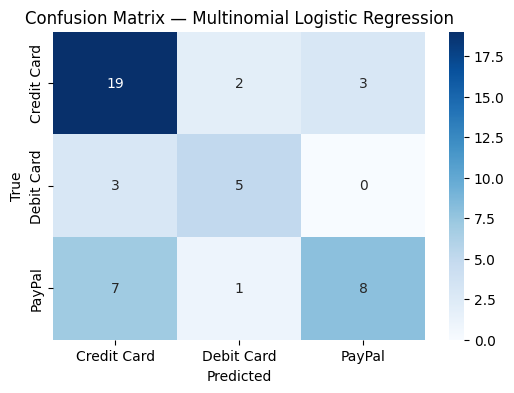

In [11]:
# ============================================================
# MULTINOMIAL LOGISTIC REGRESSION — CLEAN PIPELINE (NO LEAKAGE)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# 1️⃣ Encode Payment Method (Y variable)
# ============================================================

df["Payment_Code"] = df["Payment Method"].astype("category").cat.codes

print("Payment Method Mapping:")
print(df[["Payment Method", "Payment_Code"]].drop_duplicates(), "\n")


# ============================================================
# 2️⃣ Feature Engineering (Leak-Free)
# ============================================================

# A) Derived Features
df["HighRevenue"] = (df["Total Revenue"] > df["Total Revenue"].median()).astype(int)
df["PriceTier"]   = pd.qcut(df["Unit Price"], q=3, labels=["Low", "Mid", "High"])

# B) Final Feature Set (NO Category, NO Region, NO Product Name, NO Date)
X = pd.concat([
    df[["Total Revenue", "Units Sold", "Unit Price", "Month", "HighRevenue"]],
    pd.get_dummies(df["PriceTier"], prefix="PriceTier")
], axis=1)

y = df["Payment_Code"]

# C) Standardize numerical features
scaler = StandardScaler()
num_cols = ["Total Revenue", "Units Sold", "Unit Price", "Month"]

X_scaled = X.copy()
X_scaled[num_cols] = scaler.fit_transform(X[num_cols])


# ============================================================
# 3️⃣ Cross-Validation (10-fold Stratified)
# ============================================================

print("\n============================")
print("10-FOLD CROSS-VALIDATION (ACCURACY)")
print("============================\n")

cv_model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=500
)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(cv_model, X_scaled, y, cv=skf, scoring="accuracy")

print("CV Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Std Dev:", cv_scores.std(), "\n")


# ============================================================
# 4️⃣ Train-Test Split
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# ============================================================
# 5️⃣ Train Multinomial Logistic Regression
# ============================================================

model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=500
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n============================")
print("CLASSIFICATION REPORT — MULTINOMIAL LOGISTIC REGRESSION")
print("============================\n")
print(classification_report(y_test, y_pred))


# ============================================================
# Confusion Matrix
# ============================================================

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm, annot=True, cmap="Blues", fmt="d",
    xticklabels=df["Payment Method"].astype("category").cat.categories,
    yticklabels=df["Payment Method"].astype("category").cat.categories
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Multinomial Logistic Regression")
plt.show()

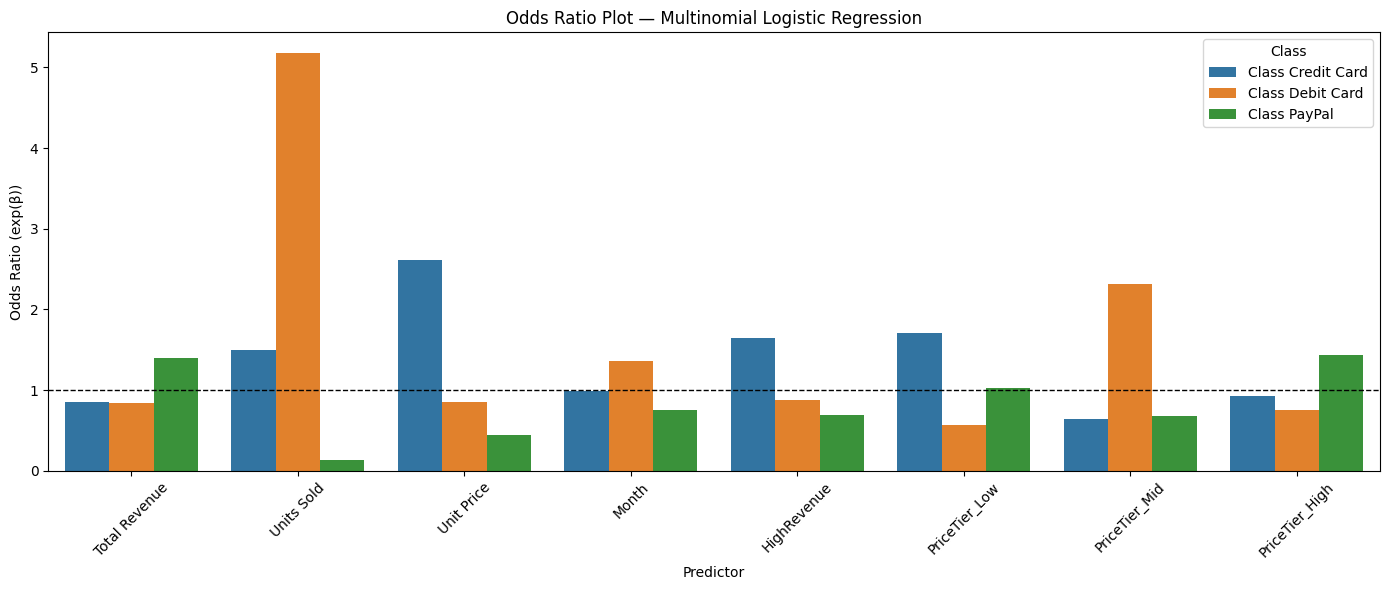

In [12]:
# ============================================================
# ODDS RATIO PLOT (MULTINOMIAL LOGISTIC REGRESSION)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get coefficient matrix (classes x predictors)
coef = model.coef_

# Exponentiate to obtain odds ratios
odds_ratios = np.exp(coef)

# Class labels
class_labels = df["Payment Method"].astype("category").cat.categories

# Create DataFrame for plotting
or_df = pd.DataFrame(
    odds_ratios, 
    columns=X_train.columns,
    index=[f"Class {c}" for c in class_labels]
)

# Reshape for seaborn-friendly plotting
or_long = or_df.reset_index().melt(id_vars="index", 
                                   var_name="Predictor", 
                                   value_name="OddsRatio")
or_long.rename(columns={"index": "Class"}, inplace=True)

plt.figure(figsize=(14, 6))
sns.barplot(data=or_long, x="Predictor", y="OddsRatio", hue="Class")

plt.axhline(1.0, color="black", linestyle="--", linewidth=1)
plt.title("Odds Ratio Plot — Multinomial Logistic Regression")
plt.ylabel("Odds Ratio (exp(β))")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



ANN CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.57      0.67      0.62        24
           1       0.30      0.38      0.33         8
           2       0.70      0.44      0.54        16

    accuracy                           0.54        48
   macro avg       0.52      0.49      0.50        48
weighted avg       0.57      0.54      0.54        48

ANN Accuracy: 0.5416666666666666 



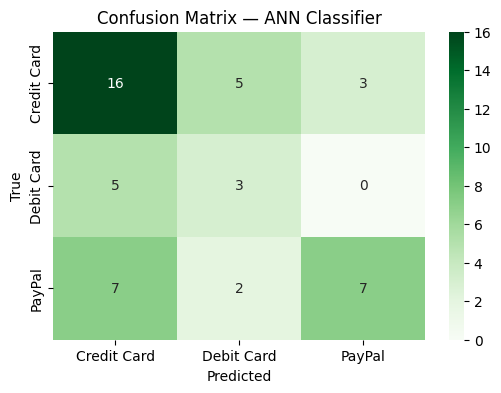

In [13]:
# ============================================================
# ARTIFICIAL NEURAL NETWORK CLASSIFIER (ANN)
# ============================================================

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# -----------------------------------------------------------
# 1️⃣ ANN Model Definition
# -----------------------------------------------------------

ann = MLPClassifier(
    hidden_layer_sizes=(32, 16),   # two hidden layers
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

# -----------------------------------------------------------
# 2️⃣ Train the ANN
# -----------------------------------------------------------

ann.fit(X_train, y_train)

# -----------------------------------------------------------
# 3️⃣ Predictions
# -----------------------------------------------------------

y_pred_ann = ann.predict(X_test)

# -----------------------------------------------------------
# 4️⃣ ANN Performance Metrics
# -----------------------------------------------------------

print("\n============================")
print("ANN CLASSIFICATION REPORT")
print("============================\n")
print(classification_report(y_test, y_pred_ann))

print("ANN Accuracy:", accuracy_score(y_test, y_pred_ann), "\n")

# -----------------------------------------------------------
# 5️⃣ Confusion Matrix Plot
# -----------------------------------------------------------

class_labels = df["Payment Method"].astype("category").cat.categories

cm = confusion_matrix(y_test, y_pred_ann)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm, annot=True, cmap="Greens", fmt="d",
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — ANN Classifier")
plt.show()



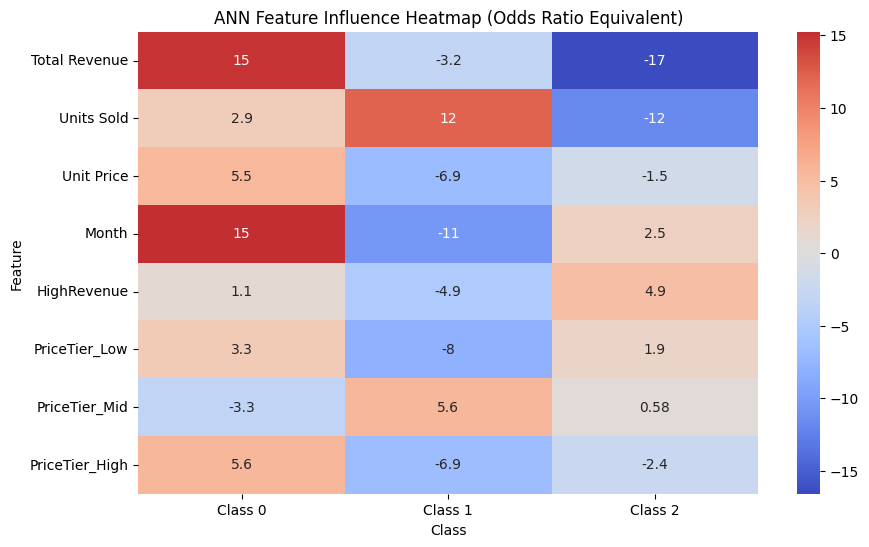

In [15]:
# ============================================================
# ANN Feature Influence (Odds-Ratio-Like Approximation)
# ============================================================

# Get model weight matrices
W1 = ann.coefs_[0]     # shape: (8 features → 32 neurons)
W2 = ann.coefs_[1]     # shape: (32 neurons → 16 neurons)
Wlast = ann.coefs_[2]  # shape: (16 neurons → n_classes)

# Matrix multiplication to approximate final feature → class impact
influence = W1 @ W2 @ Wlast   # Result: (8 features × n_classes)

# DEFINE classes (fixes the NameError)
classes = np.unique(y_train)

# Build DataFrame
infl_df = pd.DataFrame(
    influence,
    index=X_train.columns,
    columns=[f"Class {c}" for c in classes]
)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(infl_df, annot=True, cmap="coolwarm", center=0)
plt.title("ANN Feature Influence Heatmap (Odds Ratio Equivalent)")
plt.xlabel("Class")
plt.ylabel("Feature")
plt.show()



BOOTSTRAPPING STARTED...

BOOTSTRAPPING COMPLETE.

=== BOOTSTRAP ACCURACY SUMMARY ===

Mean Accuracy: 0.6567
Std Dev: 0.0316
95% CI: [0.5833, 0.7083]

=== BOOTSTRAP COEFFICIENT CI TABLE ===

          Class         Feature  Mean Coef  Lower 95%  Upper 95%
0   Credit Card   Total Revenue  -0.112405  -0.657950   0.402689
1   Credit Card      Units Sold   0.394582   0.044831   0.717451
2   Credit Card      Unit Price   0.975778   0.476549   1.488573
3   Credit Card           Month  -0.015600  -0.283072   0.235683
4   Credit Card     HighRevenue   0.495218  -0.079787   1.071513
5   Credit Card   PriceTier_Low   0.563146   0.213857   0.937159
6   Credit Card   PriceTier_Mid  -0.482660  -0.801915  -0.138735
7   Credit Card  PriceTier_High  -0.077210  -0.554388   0.365821
8    Debit Card   Total Revenue  -0.163049  -0.596950   0.241449
9    Debit Card      Units Sold   1.710728   1.330102   2.195775
10   Debit Card      Unit Price  -0.177431  -0.416035   0.039698
11   Debit Card           Mo

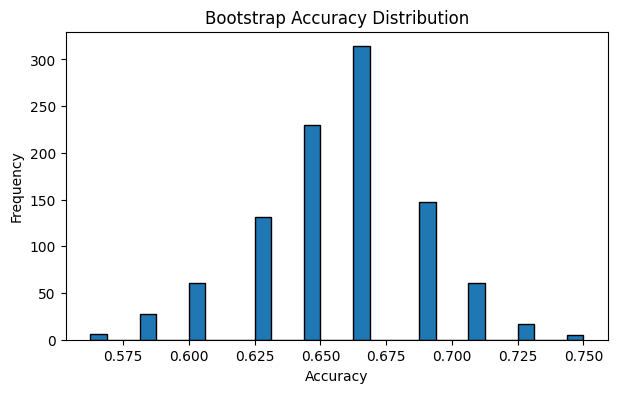

In [16]:
# ============================================================
# 🔥 BOOTSTRAPPING — MULTINOMIAL LOGISTIC REGRESSION (SKLEARN)
# ============================================================

from sklearn.utils import resample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

n_boot = 1000                  # number of bootstrap samples
boot_acc = []                  # accuracy for each bootstrap sample
boot_coefs = []                # coefficient arrays for each bootstrap

print("\n============================")
print("BOOTSTRAPPING STARTED...")
print("============================\n")

for i in range(n_boot):

    # ----------------------------------------------------------
    # 1️⃣ Bootstrap sample (WITH replacement)
    # ----------------------------------------------------------
    X_boot, y_boot = resample(
        X_train, y_train,
        replace=True,
        random_state=42 + i
    )

    # ----------------------------------------------------------
    # 2️⃣ Fit multinomial logistic regression
    # ----------------------------------------------------------
    m_boot = LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=500
    )
    m_boot.fit(X_boot, y_boot)

    # ----------------------------------------------------------
    # 3️⃣ Accuracy on TEST SET (not bootstrap set)
    # ----------------------------------------------------------
    acc = m_boot.score(X_test, y_test)
    boot_acc.append(acc)

    # ----------------------------------------------------------
    # 4️⃣ Store coefficients (K_classes × p_features)
    # ----------------------------------------------------------
    boot_coefs.append(m_boot.coef_)


# Convert bootstrap coefficients to NumPy
boot_coefs = np.array(boot_coefs)

print("BOOTSTRAPPING COMPLETE.\n")


# ============================================================
# 📌 1. BOOTSTRAP ACCURACY SUMMARY
# ============================================================

print("=== BOOTSTRAP ACCURACY SUMMARY ===\n")
print(f"Mean Accuracy: {np.mean(boot_acc):.4f}")
print(f"Std Dev: {np.std(boot_acc):.4f}")
print(f"95% CI: [{np.percentile(boot_acc, 2.5):.4f}, "
      f"{np.percentile(boot_acc, 97.5):.4f}]\n")


# ============================================================
# 📌 2. BOOTSTRAP COEFFICIENT CONFIDENCE INTERVALS
# ============================================================

K = boot_coefs.shape[1]   # number of classes
p = boot_coefs.shape[2]   # number of predictors

coef_means = boot_coefs.mean(axis=0)
coef_lower = np.percentile(boot_coefs, 2.5, axis=0)
coef_upper = np.percentile(boot_coefs, 97.5, axis=0)

coef_summary = []

feature_names = X_train.columns.tolist()
class_names = df["Payment Method"].astype("category").cat.categories.tolist()

for k in range(K):
    for j in range(p):
        coef_summary.append([
            class_names[k],          # Payment Method class
            feature_names[j],        # Predictor name
            coef_means[k, j],        # Mean coefficient
            coef_lower[k, j],        # Lower bound
            coef_upper[k, j]         # Upper bound
        ])

coef_df = pd.DataFrame(coef_summary, columns=[
    "Class", "Feature", "Mean Coef", "Lower 95%", "Upper 95%"
])

print("=== BOOTSTRAP COEFFICIENT CI TABLE ===\n")
print(coef_df)


# ============================================================
# Accuracy Distribution Plot
# ============================================================

plt.figure(figsize=(7,4))
plt.hist(boot_acc, bins=30, edgecolor='black')
plt.title("Bootstrap Accuracy Distribution")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.show()
